In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import cv2
from matplotlib import pyplot as plt
import matplotlib
import sys
import zipfile
import os
import tarfile
from python_speech_features import mfcc
#from python_speech_features import delta
from python_speech_features import logfbank
import numpy as np
import scipy.io.wavfile as wav
from six.moves.urllib.request import urlretrieve
import glob
import scipy
import random
import numpy.matlib

In [2]:
def facedet(img,h1=50,w1=120):
    """get month of from a image
    :img - image
    :h1
    :w1
    return mouth3d, left corner y, the left corner x
    """
    mouth_cascade = cv2.CascadeClassifier('/root/sharedfolder/ctc/notebooks/haarcascade_mcs_mouth.xml')
    face_cascade = cv2.CascadeClassifier('/root/sharedfolder/ctc/notebooks/haarcascade_frontalface_default.xml')

    #img = cv2.imread(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    roi_color = None
    x,y,w,h = 0,0,0,0
    offset = 0
    for (x,y,w,h) in faces:
        offset = int((w-w1)/2)
        #cv2.rectangle(img, (x,y+h), (x+w,y+h), (255,0,0), 2)
        #roi_gray = gray[y+h-h1:y+h, x+offset:x+offset+w1]
        roi_color = img[y+h-h1:y+h, x+offset:x+offset+w1]
        break
       
    return roi_color, y+h-h1, x+offset

In [3]:
def delta(feat, N):
    """Compute delta features from a feature vector sequence.
    :param feat: A numpy array of size (NUMFRAMES by number of features) containing features. Each row holds 1 feature vector.
    :param N: For each frame, calculate delta features based on preceding and following N frames
    :returns: A numpy array of size (NUMFRAMES by number of features) containing delta features. Each row holds 1 delta feature vector.
    from https://github.com/jameslyons/python_speech_features/blob/master/python_speech_features/base.py
    """
    NUMFRAMES = len(feat)
    feat = np.concatenate(([feat[0] for i in range(N)], feat, [feat[-1] for i in range(N)]))
    denom = sum([2*i*i for i in range(1,N+1)])
    dfeat = []
    for j in range(NUMFRAMES):
        dfeat.append(np.sum([n*feat[N+j+n] for n in range(-1*N,N+1)], axis=0)/denom)
    return dfeat

def preprocessAudio(audio_filename):
    """get 52 per time step features from audio file
    :audio_filename - path
    returns: array (118, 52)
    """
    fs, audio = wav.read(audio_filename)

    inputs = mfcc(audio, samplerate=fs)
    deltasF = delta(inputs,2)
    
    #mfcc_feat = mfcc(sig,rate)
    #d_mfcc_feat = delta(mfcc_feat, 2)
    fbank_feat = logfbank( audio,fs)
    inputs = np.concatenate((inputs,deltasF),1)
    #print(fbank_feat.shape)
    # Tranform in 3D array
    #print(inputs.shape)
    #train_inputs = np.asarray(inputs[np.newaxis, :])
    #train_inputs = (train_inputs - np.mean(train_inputs))/np.std(train_inputs)
    #train_seq_len = [train_inputs.shape[1]]
    #do not need 3d array!!
    result = np.concatenate((inputs,fbank_feat),1)
    #print(np.mean(result))
    #result = (result - numpy.matlib.repmat(np.mean(result,axis=1),result.shape[1],1).T)/numpy.matlib.repmat(np.std(result,axis=1),result.shape[1],1).T
    result = (result - np.mean(result))/np.mean(result)
    return result

r = preprocessAudio("bbaf2n.wav")
print (r.shape)
np.mean(r)

(118, 52)


-2.1538616175257274e-16

In [4]:


def sparse_tuple_from(sequences, dtype=np.int32):
    """Create a sparse representention of x.
    Args:
        sequences: a list of lists of type dtype where each element is a sequence
    Returns:
        A tuple with (indices, values, shape)
    """
    indices = []
    values = []

    for n, seq in enumerate(sequences):
        indices.extend(zip([n]*len(seq[0]), range(len(seq[0]))))
        values.extend(seq[0])

    indices = np.asarray(indices, dtype=np.int64)
    values = np.asarray(values, dtype=dtype)
    shape = np.asarray([len(sequences), np.asarray(indices).max(0)[1]+1], dtype=np.int64)

    return indices, values, shape

def preprocessTarget(target_filename,show=False):
    """get alignment of the words and incode into numbers
    :target_filename - path
    :return - array (length of the sentence)
    """
    # Constants
    SPACE_TOKEN = '<space>'
    SPACE_INDEX = 0
    FIRST_INDEX = ord('a') - 1  # 0 is reserved to space
    j = 0
    with open(target_filename, 'r') as f:
        original = ""
        for i,line in enumerate(f.readlines()):
            j=i            
            word = ' '.join(line.strip().lower().split(' ')[2:]).replace('.', '')
            word = word.strip()
            if word != "sil" and word != "bin" and word != "sp":
                original += " " + word
        if show:
            print (original)
        targets = original.strip().replace(' ', '  ')
        targets = targets.split(' ')
    # Adding blank label
    targets = np.hstack([SPACE_TOKEN if x == '' else list(x) for x in targets])

    # Transform char into index
    targets = np.asarray([SPACE_INDEX if x == SPACE_TOKEN else ord(x) - FIRST_INDEX
                          for x in targets])

    # Creating sparse representation to feed the placeholder
    #train_targets = sparse_tuple_from([targets])
    return targets

#todo: write decoder
def decodePrediction(d):
    """decode the alingment
    d: array of numbers that reprezent the sentence
    returns: string
    """
    SPACE_TOKEN = '<space>'
    SPACE_INDEX = 0
    FIRST_INDEX = ord('a') - 1  # 0 is reserved to space
    # Decoding
    str_decoded = ''.join([chr(x) for x in np.asarray(d[1]) + FIRST_INDEX])
    # Replacing blank label to none
    str_decoded = str_decoded.replace(chr(ord('z') + 1), '')
    # Replacing space label to space
    str_decoded = str_decoded.replace(chr(ord('a') - 1), ' ')
    return str_decoded

In [5]:
#preprocessTarget("test/align/align1/sgac4p.align",True)
#preprocessAudio("bbaf2n.wav").shape

In [6]:
def reconstructMouthPosition(imgs, points,h=50, w=120):
    """get the avarage position of the month based of the prediction
    :imgs: array of images
    :points: array (nr images, 2), coordonates of the left corner
    """
    m = np.mean(points,axis=0)
    for k,im in enumerate(imgs):
        if im.shape[0]!=h:
            gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            imgs[k] = gray[m[0]:m[0]+h, m[1]:m[1]+w]
            
def checkMouthPoints(points,h=50, w=120, dif=0.4):
    """check if there is a mouth that are far away from other detections
    points: array (nr images, 2), coordonates of the left corner
    """
    m = np.mean(points,axis=0)
    dh = int(h*dif)
    dw = int(w*120)
    for i in points:
        if abs(m[0]-i[0]) > dh or abs(m[1]-i[1]) > dw:
            return True
    return False
            
def get_frames(video, h=50, w=120,save=False):
    """get features with the mouth for each time step
    video:path
    h:
    w:
    save:
    """
    #todo: make dir if does not exit
    vidcap = cv2.VideoCapture(video)
    #success,image = vidcap.read()
    imgs = []
    trueimgs = []
    points = []
    count = 0
    ok = 0
    success = True
    while success:
      success,image = vidcap.read()
      if not success:
            break
      mouth, y,x = facedet(image,h1=50, w1=120)
      if mouth == None or mouth.shape[0]!=h or mouth.shape[1]!=w:
            print("mouth not detected:",video)
            if mouth != None:
                print(mouth.shape)
            imgs.append(image)  
            return None
            ok = 1
            continue
      points.append([y,x])
      #resize to scale hxw, and to gray
      #print(mouth.shape)
      trueimgs.append(image)
      imgs.append(mouth[:,30:90].reshape((50*60*3)))
      if save or count==1:
          cv2.imwrite("mouth/frame"+video+".jpg", mouth)     # save frame as JPEG file
      #todo: get a fixed size photo of the mouth, return the images
      count += 1
      if count == 80 and False: 
        break
      if count % 10 == 0 and False:
          #print count
          print("{0}-frames/frame{1}.jpg".format(video, count))
    if count != 75:
          print("number of frames:",count)
          print(video)
          return None
    if ok==1:
        #maybe return None
        return None
        print("reconstruct needed")
        reconstructMouthPosition(imgs, np.asarray(points))
    if checkMouthPoints(np.asarray(points)):#there is mouth detected far from other detections
        print(points)
        return None
    mn = np.mean(np.asarray(points),axis=0)
    #print(mn)
    trueimgs = np.asarray(trueimgs)
    result = trueimgs[:,mn[0]:mn[0]+50,mn[1]+20:mn[1]+100].reshape((75,80*50*3))
    #result = (result - numpy.matlib.repmat(np.mean(result,axis=1),result.shape[1],1).T)/numpy.matlib.repmat(np.std(result,axis=1),result.shape[1],1).T
    result = (result - np.mean(result))/np.mean(result)
    return result

In [7]:
t=get_frames("test/video/s1/bbaf2n.mpg",save=True)
%matplotlib inline
import matplotlib.pyplot as plt

def show_class_images1(imgs, cols):
    plt.figure(figsize=(25,25))
    rows = int(imgs.shape[0]/cols)
    if imgs.shape[0] > cols*rows:
        rows += 1
    for i,img in enumerate(imgs):
        plt.subplot(rows,cols,i)
        plt.axis('off')
        plt.imshow(img)#,cmap='gray')
        
#plt.imshow(dataA[20][3],cmap="gray")
#show_class_images1(t.reshape((75,50,80,3)),5)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:69: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [8]:
def getBatch(batchSize, epoch=0, fileNames=False,randomIds=False, database=False,saveAll=False, fromFile=False):
    #what is better, to save in memory or to read from file every time>>??
    #openfile    
    if fileNames != False:
        video=scipy.io.loadmat(fileNames[0])['video'][0]
        audio=scipy.io.loadmat(fileNames[1])['audio'][0]
        align=scipy.io.loadmat(fileNames[2])['align'][0]        
        database = [audio,align,video]
    
    assert batchSize < len(database[0])
    #print(len(database[0]))
    mask = np.ones(len(database[0]),dtype=bool)
    if randomIds:
        b = random.sample(range(10, len(database[0])), batchSize)        
    else:
        offset = (batchSize*epoch)%len(database[0])
        b = np.zeros(batchSize,dtype=np.int32)
        b[:min(offset+batchSize,len(database[0]))-offset] = np.arange(offset,min(offset+batchSize,len(database[0]))) 
        if offset+batchSize > len(database[0]):
            b[min(offset+batchSize,len(database[0]))-offset:] = np.arange(offset+batchSize-len(database[0]),dtype=np.int32)
    #print(b)
    mask[b] = False
    data = [database[0][mask],database[1][mask],database[2][mask]]    
    return data

In [9]:
s = getBatch(20,3,['test/video-2-test.mat','test/audio-2-test.mat','test/align-2-test.mat'],randomIds=True)
print(s[0][0].shape)
print(s[1][0].shape)
print(s[2][0].shape)

(130, 13)
(1, 21)
(75, 50, 120)


In [55]:

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for
    users with slow internet connections. Reports every 1% change in download
    progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
        last_percent_reported = percent
def download_dataBase(path="GridCorpus",nrT=35,force=False, download=True, preprocess=False, batchSize=False,extract=True, allow=False,parts=False):
    """download gridcorpus and get the features from videos, audios and tokenize the alignment
    :path: path where to save the dataset
    nrT: number of people to process -1
    force: if to redownload
    download:
    preprocess:
    batchSize: how many items in a batch
    extract:
    parts: what to not process array of values - 0 - audio, 1-align, 2-video
    """
    #no 21 speaker, 1->34
    urlAu  = "http://spandh.dcs.shef.ac.uk/gridcorpus/s{0}/audio/s{1}.tar"
    urlAl  = "http://spandh.dcs.shef.ac.uk/gridcorpus/s{0}/align/s{1}.tar"
    urlVi  = "http://spandh.dcs.shef.ac.uk/gridcorpus/s{0}/video/s{1}.mpg_vcd.zip"
    l = [urlAu,urlAl,urlVi]
    a = ['audio', 'align', 'video']
    n = ["s{0}.tar","s{0}.tar","s{0}.mpg_vcd.zip"]
    b = ["s{0}","align","s{0}"]
    c = [preprocessAudio,preprocessTarget,get_frames]
    e = ["wav","align","mpg"]
    #if database not exist->create folder with align, video, audio
    if not os.path.exists(path):
        os.makedirs(path)
    for i in range(3):
        if not os.path.exists(path+"/"+a[i]):
            os.makedirs(path+"/"+a[i])
    #download database
    for i in range(1,nrT):#34 speacker->nrT=35
        if i == 21:
            continue
        if download:
          for j in range(3):
            filename = n[j].format(i)
            if force or not os.path.exists(path + "/" +a[j] + "/" + filename):
                print('Attempting to download {0}:'.format(a[j]), filename)
                filename, _ = urlretrieve(l[j].format(i,i), path + "/" +a[j] + "/" + filename,
                                          reporthook=download_progress_hook)
                #unzip/extract files???
                if extract:
                    filename = path + "/" +a[j] + "/" + n[j].format(i)
                    if j == 2:
                        with zipfile.ZipFile(filename,"r") as zip_ref:
                            zip_ref.extractall(path + "/" +a[j])
                    else:
                        with tarfile.open(filename) as tfile:
                            tfile.extractall(path + "/" +a[j])
                            tfile.close()
                        if j == 1:
                            os.rename(path + "/" +a[j]+"/align", path + "/" +a[j]+"/align{0}".format(i))
    if batchSize != False:
        batchpath = path+"/batch-{0}-{1}".format(nrT,batchSize)
        if not os.path.exists(batchpath):
            os.makedirs(batchpath)
    
    if  preprocess:     
        nameFileTrain='/{0}-{1}-train52Color80x50-all_{2}.mat'
        nameFileTest='/{0}-{1}-test52Color80x50-all_{2}.mat'
        batchNr = 0
        data = [[],[],[]]
        test_data = [[],[],[]]
        names_data = [[],[],[]]
        names_test_data = [[],[],[]]
        names = [[],[],[]]
        toDelete = []#we can save here the file name and check it everytime - video first proccessed
        coruptNames = []
        nrItemsG = 0
        for j in np.arange(3)[::-1]:
                if parts!=False and j in parts:
                    continue
                #preprocesing: audio - mccf, video - frame/mouth, text - words to numbers!! may all at once after??
                if batchSize == False or True :#and  os.path.exists(path+'/{0}-{1}.mat'.format(a[j],nrT)):
                    mypath = path + "/" +a[j]#???
                    print(mypath)
                    dataT = []                    
                    dataTN = []
                    length = []
                    count1 = 1
                    nrItems=0
                    batchNr = 0
                    if batchSize and nrItems>0:
                        dataT = data[j][0]   + test_data[j][0]                 
                        dataTN = names_data[j][0] + names_test_data[j][0]
                        length = data[j][1]   + test_data[j][1]
                        data[j] = []
                        test_data[j] = []
                        names_data[j] = []
                        names_test_data[j] = []
                    for f in sorted(os.listdir(mypath)):
                        if os.path.isdir(mypath+"/"+f):
                            if count1 == nrT :
                                break
                            count1 = count1+1
                            print(f)
                            
                            for f1 in sorted(glob.glob(mypath+"/"+f+"/*."+e[j])):#just first 100 items
                                nn = f1.split('/')[-1].split('.')[0]+"/{0}".format(count1)
                                if nn in coruptNames:
                                    continue                               
                                if allow!=False and  nn not in allow[2] :
                                    #print(nn,allow)
                                    continue
                                val = c[j](f1)
                                if val==None:
                                    #toDelete.append(len(dataT))
                                    coruptNames.append(nn)
                                    continue
                                nrItems = nrItems + 1
                                dataT.append(val)
                                length.append(len(val))
                                names[j].append(nn)
                                dataTN.append(f1.split('/')[-1]+"/"+f)
                                if batchSize and nrItems%batchSize==0 and nrItems>0:
                                    scipy.io.savemat(batchpath+nameFileTrain.format(a[j],nrT,batchNr), 
                                                     mdict={a[j]: np.asarray(dataT), 
                                                            "lengths":np.asarray(length),    
                                                            a[j]+"-names":np.asarray(dataTN)})
                                    dataT = []
                                    length = []
                                    dataTN = []
                                    batchNr = batchNr + 1
                                    nrItems = 0
                    if len(dataT)>0:
                        data[j].append(np.asarray(dataT[::2]))
                        test_data[j].append(np.asarray(dataT[1::2]))
                        data[j].append(np.asarray(length[::2]))
                        test_data[j].append(np.asarray(length[1::2]))

                        names_data[j].append(np.asarray(dataTN[::2]))
                        names_test_data[j].append(np.asarray(dataTN[1::2]))
        #saving data as array in file: audio.mat, video.mat, text.mat
        if len(toDelete)>0:
            for k,dl in enumerate(toDelete):
                for j in range(3):
                    del data[dl-k]
        #verify if none exist in data
        for k,dt in enumerate(data[0]):
            for j in range(3):
                if parts!=False and j in parts:
                    continue
                if data[j][k]==None:
                    print("there is a None in the process data!!!")
        if batchSize != False:
            path = batchpath
        for j in range(3):
            if parts!=False and j in parts:
                continue
            if len(data[j][0])>0:
                scipy.io.savemat(path+nameFileTrain.format(a[j],nrT,batchNr), mdict={a[j]: np.asarray(data[j][0]), "lengths":np.asarray(data[j][1]),    a[j]+"-names":np.asarray(names_data[j][0])})
            if batchSize == False:
                scipy.io.savemat(path+nameFileTest.format(a[j],nrT,batchNr) , mdict={a[j]: np.asarray(test_data[j][0]),  "lengths":np.asarray(test_data[j][1]), a[j]+"-names":np.asarray(names_test_data[j][0])})
              
        return names

In [56]:
last_percent_reported = None
#download_dataBase(path="test",nrT=2)

In [1]:
#names = download_dataBase(path="test",nrT=3,download=True, preprocess=True, batchSize=50,parts=[0])

In [73]:
#names1 = download_dataBase(path="test",nrT=2,download=True, preprocess=True, batchSize=False,parts=[2],allow=names)
#data.shape

In [74]:
#names1 = download_dataBase(path="test",nrT=2,download=True, preprocess=True, batchSize=False,parts=[2,0],allow=names)

In [68]:
dataA = scipy.io.loadmat("test/batch-3-50/video-3-train52Color80x50-all_36.mat")['video-names']
dataA1 = scipy.io.loadmat("test/batch-3-50/align-3-train52Color80x50-all_36.mat")['align-names']

In [71]:

print(dataA[0][0])
print(dataA1)
#names
#dataA[0]
#sparse_tuple_from(dataA[:10])

swar7a.mpg/s10
[[u'swar7a.align/align10' u'sway9s.align/align10' u'swazzp.align/align10'
  u'swbf3a.align/align10' u'swbl4n.align/align10' u'swbl6p.align/align10'
  u'swbr8n.align/align10' u'swbs1a.align/align10' u'swbz2n.align/align10'
  u'swbz4p.align/align10' u'swie2n.align/align10' u'swie5a.align/align10'
  u'swik7s.align/align10' u'swir1s.align/align10' u'swir3a.align/align10'
  u'swiy6p.align/align10' u'swwf4n.align/align10' u'swwf7a.align/align10'
  u'swwm1a.align/align10' u'swws3s.align/align10' u'swws5a.align/align10'
  u'swwz7s.align/align10']]


In [63]:
#verificate integrity of database
if False:
  for j,m in enumerate(names[0]):
    ok = 1
    w1 = m.split(".")[0]
    for i,n in  enumerate(names[1]):
        w = n.split(".")[0]
        if w1 == w:
            ok = 0
            break
    if ok == 1:
        print (m)

In [64]:
#print(names[0][10])
#print(names[1][10])

In [65]:
#print(len(names[0]))

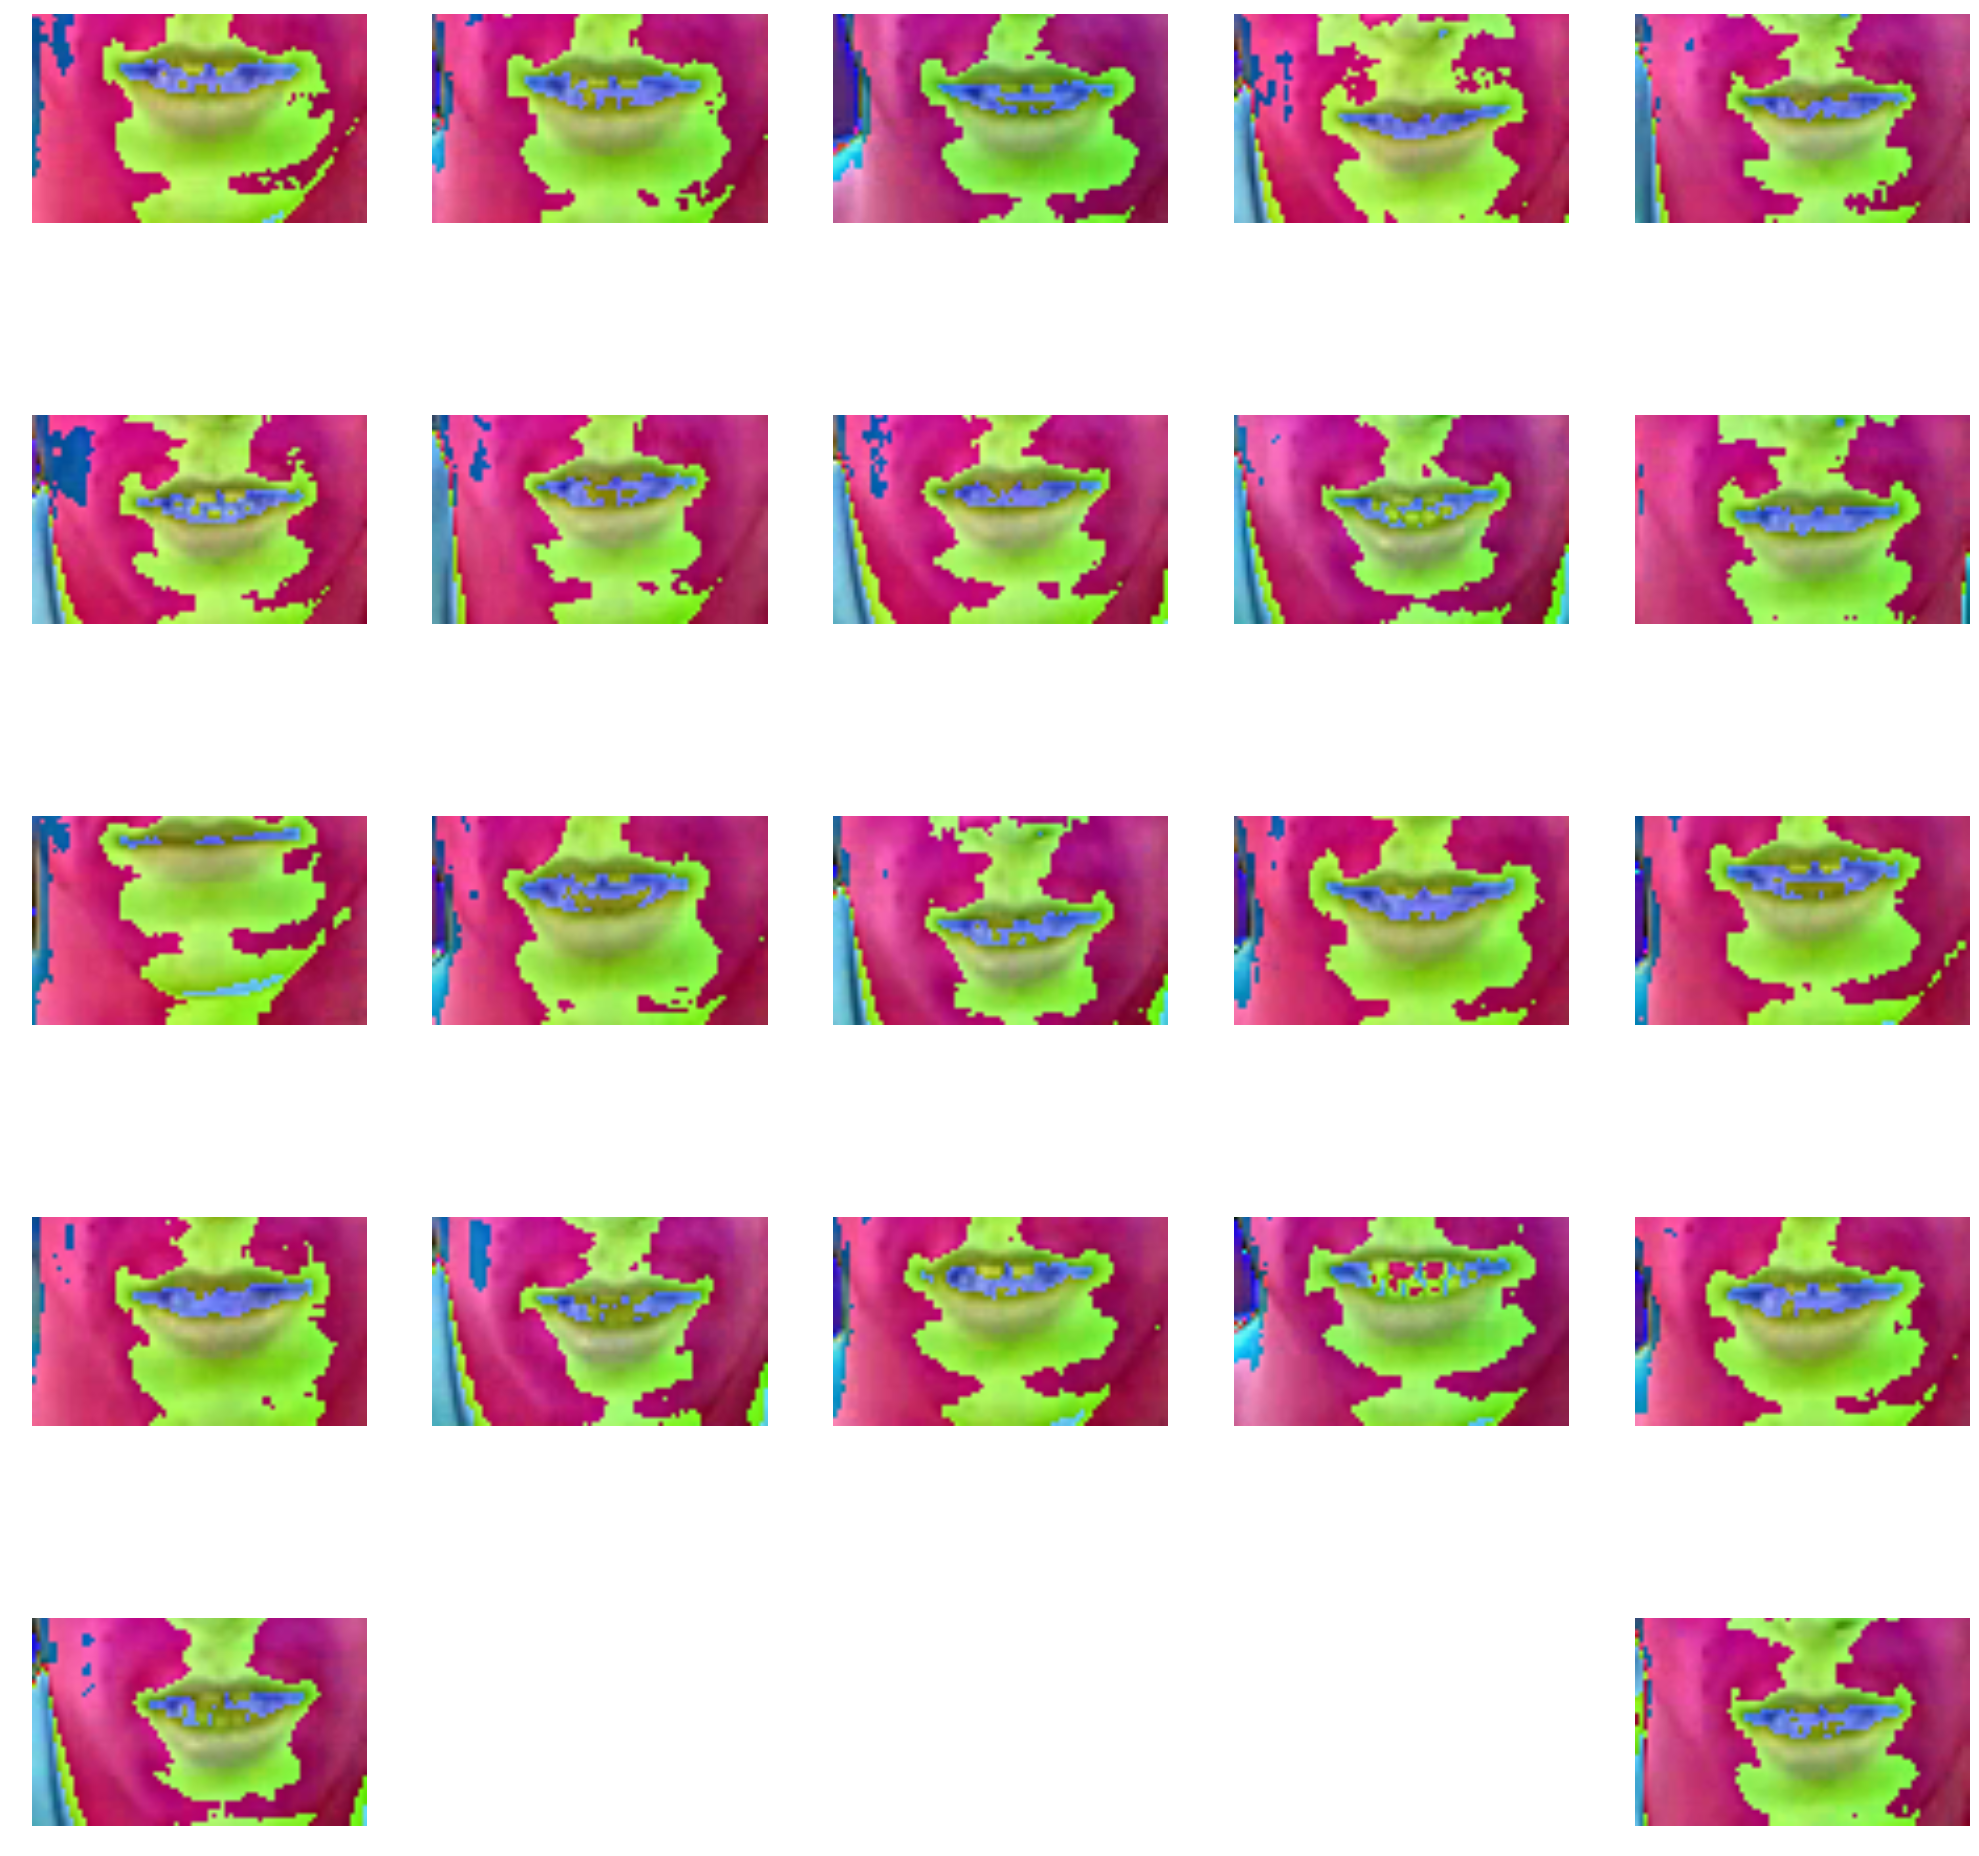

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_class_images1(imgs, cols):
    plt.figure(figsize=(25,25))
    rows = int(imgs.shape[0]/cols)
    if imgs.shape[0] > cols*rows:
        rows += 1
    for i,img in enumerate(imgs):
        plt.subplot(rows,cols,i)
        plt.axis('off')
        plt.imshow(img)#,cmap='gray')
        
#plt.imshow(dataA[20][3],cmap="gray")
show_class_images1(dataA[:,10,:].reshape((-1,50,80,3)),5)

In [105]:
def batch_to_words_batch(db,path,name,words):
    """make a batch from words from sentences
    db:path to database
    path:path to batch
    name:path to bath of video to process,
    words:"""
    #swar7a.mpg/s10
    #swar7a.align/align10
    # Constants
    SPACE_TOKEN = '<space>'
    SPACE_INDEX = 0
    FIRST_INDEX = ord('a') - 1  # 0 is reserved to space
    
    dataA = scipy.io.loadmat(name)['video-names']
    dataV = scipy.io.loadmat(name)['video']
    #print(dataV.shape)
    #newData = []
    dataNV = []
    lengthNV = []
    namesNV = []
    dataNA = []
    lengthNA = []
    namesNA = []
    for j,i in enumerate(dataA):
        filename = '/align'+i.split('mpg/s')[1]+'/'+i.split('mpg/s')[0]+'align'
        #print(filename)
        with open(db+'align'+filename, 'r') as f:
            original = ""
            for i,line in enumerate(f.readlines()):
                #j=i            
                begin = int(int(line.strip().lower().split(' ')[0])/1000)
                end = int(int(line.strip().lower().split(' ')[1])/1000)
                
                word = ' '.join(line.strip().lower().split(' ')[2:]).replace('.', '')
                word = word.strip()
                if word != "sil" and word != "bin" and word != "sp":
                    original += " " + word
                    targets = word.strip().replace(' ', '  ')
                    targets = targets.split(' ')
                    # Adding blank label
                    targets = np.hstack([SPACE_TOKEN if x == '' else list(x) for x in targets])

                    # Transform char into index
                    targets = np.asarray([SPACE_INDEX if x == SPACE_TOKEN else ord(x) - FIRST_INDEX
                                          for x in targets])
                    #print(begin,end,word,targets)
                    if end > begin+3:
                        dataNV.append(dataV[j,begin:end,:])
                        lengthNV.append(end-begin)
                        namesNV.append(filename)
                        dataNA.append(targets)
                        lengthNA.append(len(targets))
                        namesNA.append(filename)
            #print (original)
    save = name.split('/')[-1].split('.mat')[0]
    #return np.asarray(dataNV[4])
    print (path+save+"_words.mat")
    if True:
        scipy.io.savemat(path+save+"_words.mat", mdict={'video': np.asarray(dataNV), 
                                                    "lengths":np.asarray(lengthNV),   
                                                    "video-names":np.asarray(namesNV)})
        save = save.replace("video",'align')
        print(path+save+"_words.mat")
        scipy.io.savemat(path+save+"_words.mat", mdict={'align': np.asarray(dataNA), 
                                                    "lengths":np.asarray(lengthNA),   
                                                    "align-names":np.asarray(namesNA)})
            
#database, batch dir, file path, words
d=batch_to_words_batch("test/","test/batch-3-50/","test/batch-3-50/video-3-train52Color80x50-all_35.mat",[0,1,2,3,4])
#show_class_images1(d.reshape((-1,50,80,3)),5)

test/batch-3-50/video-3-train52Color80x50-all_35_words.mat
test/batch-3-50/align-3-train52Color80x50-all_35_words.mat


In [106]:
def process1_batch(path,nr):
    for f1 in sorted(glob.glob(path+"/*.mat")):
        if nr == 0:
            break
        if f1.find('video')!=-1 and f1.find('words')==-1:
            nr = nr -1
            print(f1)
            batch_to_words_batch("test/",path,f1,[])
process1_batch("test/batch-3-50/",2)

test/batch-3-50/video-3-train52Color80x50-all_0.mat
test/batch-3-50/video-3-train52Color80x50-all_0_words.mat
test/batch-3-50/align-3-train52Color80x50-all_0_words.mat
test/batch-3-50/video-3-train52Color80x50-all_1.mat
test/batch-3-50/video-3-train52Color80x50-all_1_words.mat
test/batch-3-50/align-3-train52Color80x50-all_1_words.mat
